In [141]:
%reset -f
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

In [142]:
del configs[:]
initial_conditions = {
    'T': 20,
    's': 0.75,
    'tl': 0,
    'l': 1,
}

params = {
    'T_bp_chg_min': [-500],
    'T_bp_chg_max': [500],
    'T_s_chg_min': [-10],
    'T_s_chg_max': [10],
    'l': [5,10,15,19],
}

MONTE_CARLO_RUNS = 2
SIMULATION_TIMESTEPS = range(10000)
simulation_parameters = {
    'N': MONTE_CARLO_RUNS,
    'T': SIMULATION_TIMESTEPS,
    'M': params
}

In [143]:
def p_T_chg(_params, substep, state_history, state_current, **kwargs):
    random_bp_chg = np.random.randint(_params['T_bp_chg_min'], high=_params['T_bp_chg_max'])
    random_T_chg = random_bp_chg * 0.0001
    return {'T_chg': random_T_chg}

def p_s_chg(_params, substep, state_history, state_current, **kwargs):
    random_s_int_chg = np.random.randint(_params['T_s_chg_min'], high=_params['T_s_chg_max'])
    random_s_chg = random_s_int_chg * 0.001
    return {'s_chg': random_s_chg}

def p_l_chg(_params, substep, state_history, state_current, **kwargs):
    return {'l': _params['l']}

In [144]:
def s_T_update(_params, substep, state_history, state_current, _input, **kwargs):
    new_T = state_current['T'] + (_input['T_chg'] * state_current['T'])
    return ('T', new_T)

def s_s_update(_params, substep, state_history, state_current, _input, **kwargs):
    new_s_tmp = state_current['s'] + (_input['s_chg'] * state_current['s'])
    new_s = new_s_tmp if new_s_tmp > 0.1 else 0.1
    return ('s', new_s)

# **********************************************************************************************
# LIMIT ORDER TOKEN RESERVE token valuation model
# tl = l*e^(s*(l-T)) for LOTR token value above the limit order price threshold constant
# tl = l*e^(s*(T-l)) for LOTR token value below the limit order price threshold constant
# tl = Limit Token price
# T = target token price
# l = Limit Order price
# s = $Token variance constant
# **********************************************************************************************
def s_lotr_update(_params, substep, state_history, state_current, _input, **kwargs):
    new_T = state_current['T'] + (_input['T_chg'] * state_current['T'])
    l = _input['l']
    
    # The token valuation equation is slightly different depending on whether
    # the target limit price is above or below the current target token price.
    # g = Le^(v(s)) where s = L-p or p-L, the asset price vs. Gandalf token spread
    spread = 0
    if new_T > l:
        # s = L-p
        spread = l - new_T
    elif new_T < l:
         # s = p-L
        spread = new_T - l

    new_tl = l * np.exp(state_current['s'] * spread)
    return ('tl', new_tl)

def s_l_update(_params, substep, state_history, state_current, _input, **kwargs):
    return ('l', _input['l'])

In [145]:
partial_state_update_blocks = [
    { 
        'policies': {
            'T_chg': p_T_chg,
            's_chg': p_s_chg,
            'l': p_l_chg
        },
        'variables': {
            'T': s_T_update,
            's': s_s_update,
            'tl': s_lotr_update,
            'l': s_l_update
        }
    }
]

In [146]:
sim_config = config_sim(simulation_parameters)

exp = Experiment()
exp.append_configs(sim_configs=sim_config, 
                   initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks)

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context=exec_context, configs=configs) 
(records, tensor_field, session) = executor.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 4
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10000, 5, 2, 4)
Execution Method: local_simulations
SimIDs   : [0, 0, 1, 1, 2, 2, 3, 3]
SubsetIDs: [0, 0, 1, 1, 2, 2, 3, 3]
Ns       : [0, 1, 0, 1, 0, 1, 0, 1]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 2.62s


In [147]:
df = pd.DataFrame(records)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_rows", 10, "display.max_columns", 10)
df.set_index(['simulation', 'run', 'timestep', 'substep'])

T         s        tl   l  subset
simulation run timestep substep                                           
0          1   0        0        20.000000  0.750000  0.000000   1       0
               1        1        20.452000  0.754500  0.000046   5       0
               2        1        20.472452  0.756009  0.000043   5       0
               3        1        20.189932  0.756009  0.000051   5       0
               4        1        19.531740  0.759789  0.000085   5       0
...                                    ...       ...       ...  ..     ...
3          2   9996     1        70.040397  0.100400  0.115371  19       3
               9997     1        71.343149  0.100000  0.099181  19       3
               9998     1        72.677266  0.100300  0.088630  19       3
               9999     1        72.640927  0.100000  0.087532  19       3
               10000    1        76.105899  0.100000  0.062904  19       3

[80008 rows x 5 columns]

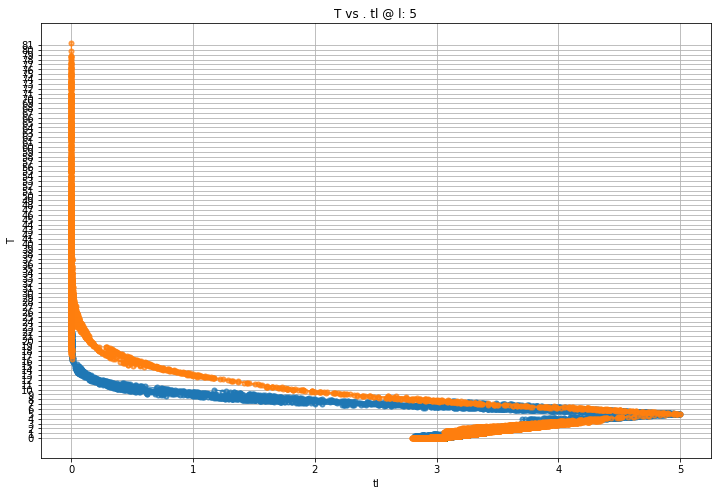

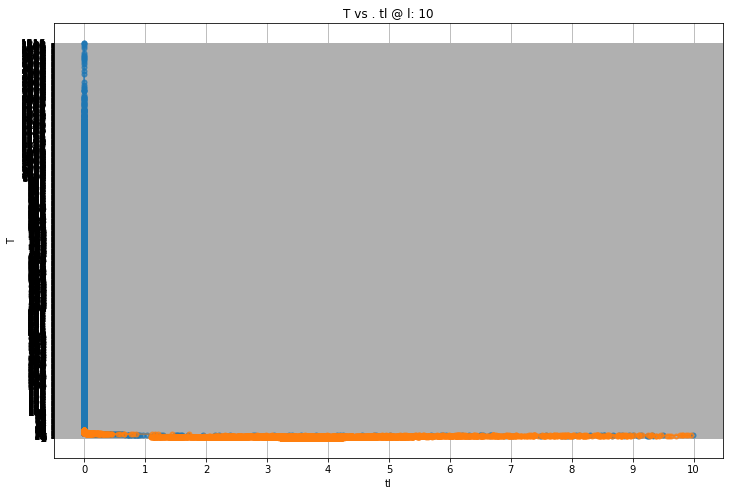

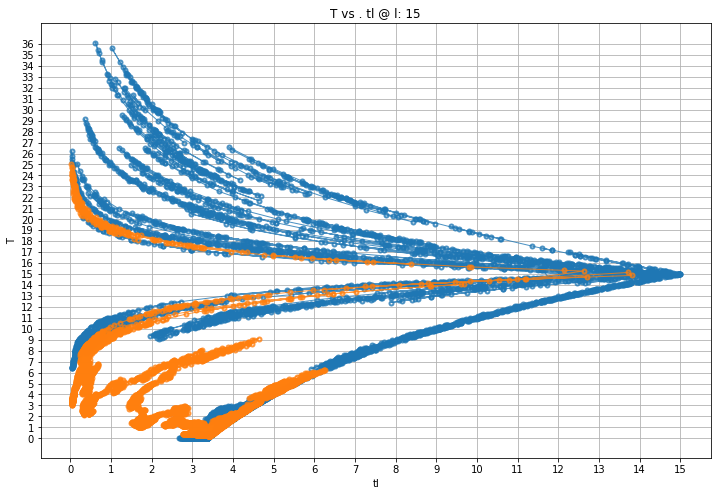

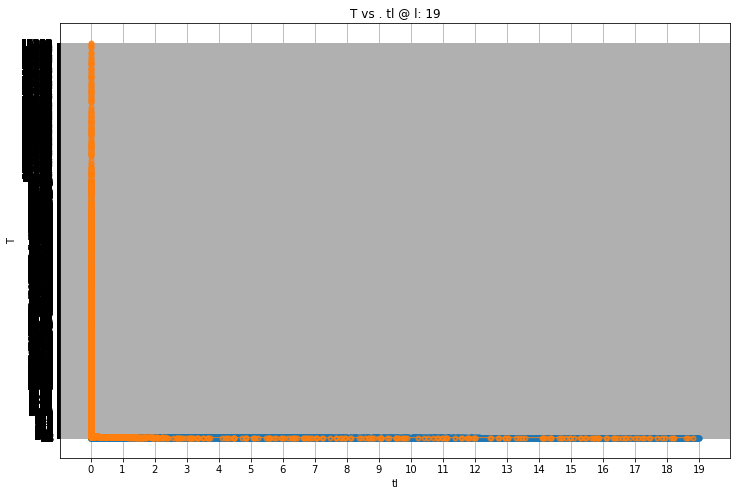

In [148]:
for simulation_id in range(4):
    ax = None
    for i in range(0, MONTE_CARLO_RUNS):
        ax =  df[(df['simulation']==simulation_id) & (df['run']==i+1) & (df['timestep']>0)].plot(x='tl', y=['T'], marker='o', markersize=2,
                    markeredgewidth=4, alpha=0.8, markerfacecolor='black',
                    linewidth=1, figsize=(12,8),  title="T vs . tl @ l: " + str(np.max(df[(df['simulation']==simulation_id)]['l'])), 
                    ylabel='T', grid=True, fillstyle='none',  
                    xticks=list(range(1+np.int64(np.max(df[(df['simulation']==simulation_id)]['l'])))), legend=None,
                    yticks=list(range(1+np.int64(np.max(df[(df['simulation']==simulation_id)]['T'])))), ax=ax);
#                     yticks=list(range(1+(df[(df['simulation']==simulation_id)]['T']).max())), ax=ax);